# ViT Prototype: 5-Channel 32x32 Network Payload Classification (2500 Samples)

**Objective:** Evaluate Vision Transformer performance on 5-channel 32x32 image representations with **2500 samples per class** for fair comparison with UNSW dataset.

## Overview

This notebook adapts the ViT prototype for **5-channel 32x32 images** with a **2500 sample limit per class**, enabling direct comparison with UNSW dataset results. The 5-channel encoding provides rich multi-dimensional representation of payload bytes.

## Key Configuration

- **Image Format:** 5-channel 32x32 images (5 × 32 × 32 = 5,120 dimensional)
- **Sample Limit:** 2500 samples per class (for fair comparison)
- **Dataset Source:** `/home/ubuntu/analyst/pcap-dataset-samples/parquet/5channel_32x32/`
- **Classes:** 9 attack types (same as original)
- **Architecture:** ViT with 16×16 patches, adapted for multi-channel input

## Dataset Structure

- **Format:** Apache Parquet files with train/val/test splits
- **Channels:** 5 channels representing different aspects of payload data
- **Size:** 32×32 pixel resolution per channel
- **Limit:** Maximum 2500 samples per class for controlled comparison

In [1]:
# Section 1: Environment Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

# Configuration for 5-channel ViT with sample limit
CONFIG = {
    'image_size': 32,          # 32x32 images
    'channels': 5,             # 5-channel input
    'patch_size': 16,          # 16x16 patches
    'embed_dim': 192,          # Embedding dimension  
    'num_heads': 3,            # Attention heads
    'num_layers': 6,           # Transformer layers
    'batch_size': 32,
    'learning_rate': 1e-4,
    'epochs': 30,
    'num_classes': 9,          # Fixed to 9 classes
    'max_samples_per_class': 2500  # NEW: Limit for fair comparison with UNSW
}

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ Environment setup complete")
print(f"✓ Device: {device}")
print(f"✓ Target: {CONFIG['channels']}-channel {CONFIG['image_size']}x{CONFIG['image_size']} → ViT classification")
print(f"✓ Sample limit: {CONFIG['max_samples_per_class']} per class")

✓ Environment setup complete
✓ Device: cpu
✓ Target: 5-channel 32x32 → ViT classification
✓ Sample limit: 2500 per class


In [2]:
# Load 5-channel 32x32 dataset from parquet files with 2500 sample limit
data_path = '/home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/'
print(f"Loading 5-channel 32x32 dataset from: {data_path}")
print(f"Sample limit: {CONFIG['max_samples_per_class']} per class")

def load_parquet_data_limited(base_path, max_samples_per_class):
    """Load parquet files with sample limit per class"""
    all_image_data = []
    all_labels = []
    splits = ['train', 'val', 'test']
    
    # Get all class directories - SORT for consistency
    class_dirs = sorted([d for d in glob.glob(f"{base_path}*/") if not any(s in d for s in splits)])
    class_names = [d.split('/')[-2] for d in class_dirs]
    print(f"Found classes: {class_names}")
    
    for class_dir in class_dirs:
        class_name = class_dir.split('/')[-2]
        print(f"Loading {class_name} (max {max_samples_per_class} samples)...")
        
        class_samples = 0
        
        for split in splits:
            if class_samples >= max_samples_per_class:
                break
                
            split_path = f"{class_dir}{split}/"
            parquet_files = sorted(glob.glob(f"{split_path}*.parquet"))  # SORT for consistency
            
            for file_path in parquet_files:
                if class_samples >= max_samples_per_class:
                    break
                    
                try:
                    df = pd.read_parquet(file_path)
                    
                    # Extract image data from the 'image_data' column
                    if 'image_data' in df.columns:
                        # Limit samples from this file
                        remaining_samples = max_samples_per_class - class_samples
                        samples_to_take = min(len(df), remaining_samples)
                        
                        # Convert list-based image data to numpy arrays
                        for idx in range(samples_to_take):
                            row = df.iloc[idx]
                            image_data = np.array(row['image_data'], dtype=np.float32)
                            all_image_data.append(image_data)
                            all_labels.append(class_name)
                            class_samples += 1
                        
                        print(f"   Loaded {samples_to_take} samples from {file_path.split('/')[-1]} (total: {class_samples})")
                    else:
                        print(f"   Warning: No 'image_data' column found in {file_path.split('/')[-1]}")
                        
                except Exception as e:
                    print(f"   Error loading {file_path}: {e}")
    
    if not all_image_data:
        raise ValueError("No image data was loaded successfully!")
    
    # Convert to numpy arrays
    X = np.array(all_image_data, dtype=np.float32)
    y = np.array(all_labels)
    
    print(f"\n✓ Total samples loaded: {len(X)}")
    print(f"✓ Image data shape: {X.shape}")
    print(f"✓ Unique labels: {np.unique(y)}")
    
    return X, y

# Load the limited dataset
X, y = load_parquet_data_limited(data_path, CONFIG['max_samples_per_class'])

print(f"\n✓ Data preparation:")
print(f"   X shape: {X.shape}")
print(f"   Expected features: {CONFIG['channels']} × {CONFIG['image_size']}² = {CONFIG['channels'] * CONFIG['image_size']**2}")
print(f"   y shape: {y.shape}")

# Verify the data matches expected dimensions
expected_features = CONFIG['channels'] * CONFIG['image_size'] ** 2
if X.shape[1] == expected_features:
    print(f"✓ Feature count matches expected: {X.shape[1]} == {expected_features}")
else:
    print(f"⚠️  Feature count mismatch: got {X.shape[1]}, expected {expected_features}")

# Encode labels and ensure we have exactly 9 classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
actual_classes = len(label_encoder.classes_)

print(f"\n✓ Label encoding (limited to {CONFIG['max_samples_per_class']} per class):")
for i, label in enumerate(label_encoder.classes_):
    count = np.sum(y == label)
    print(f"   {i}: {label} ({count:,} samples)")

# If we don't have exactly 9 classes, adjust CONFIG
if actual_classes != CONFIG['num_classes']:
    print(f"\n⚠️  Adjusting from {CONFIG['num_classes']} to {actual_classes} classes based on data")
    CONFIG['num_classes'] = actual_classes

# Verify data range and quality
print(f"\n✓ Data quality:")
print(f"   Value range: [{X.min():.3f}, {X.max():.3f}]")
print(f"   Missing values: {np.isnan(X).sum()}")
print(f"   Non-zero features per sample (avg): {np.mean(np.count_nonzero(X, axis=1)):.1f}")

Loading 5-channel 32x32 dataset from: /home/ubuntu/analyst/notebooks/ViT-experiment/pcap-dataset-samples/parquet/5channel_32x32/
Sample limit: 2500 per class
Found classes: ['Benign_Final', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DictionaryBruteForce', 'DoS-TCP_Flood', 'DoS-UDP_Flood', 'Mirai-udpplain', 'Recon-PortScan', 'SqlInjection']
Loading Benign_Final (max 2500 samples)...
   Loaded 1000 samples from shard_00000.parquet (total: 1000)
   Loaded 1000 samples from shard_00001.parquet (total: 2000)
   Loaded 500 samples from shard_00002.parquet (total: 2500)
Loading DDoS-HTTP_Flood (max 2500 samples)...
   Loaded 1000 samples from shard_00000.parquet (total: 1000)
   Loaded 1000 samples from shard_00001.parquet (total: 2000)
   Loaded 500 samples from shard_00002.parquet (total: 2500)
Loading DDoS-SYN_Flood (max 2500 samples)...
   Loaded 1000 samples from shard_00000.parquet (total: 1000)
   Loaded 1000 samples from shard_00001.parquet (total: 2000)
   Loaded 500 samples from shard_00

Reshaping data to 5-channel images...
✓ Reshaped to: (22500, 5, 32, 32)

Visualizing sample images for 9 classes (2500 sample limit)...


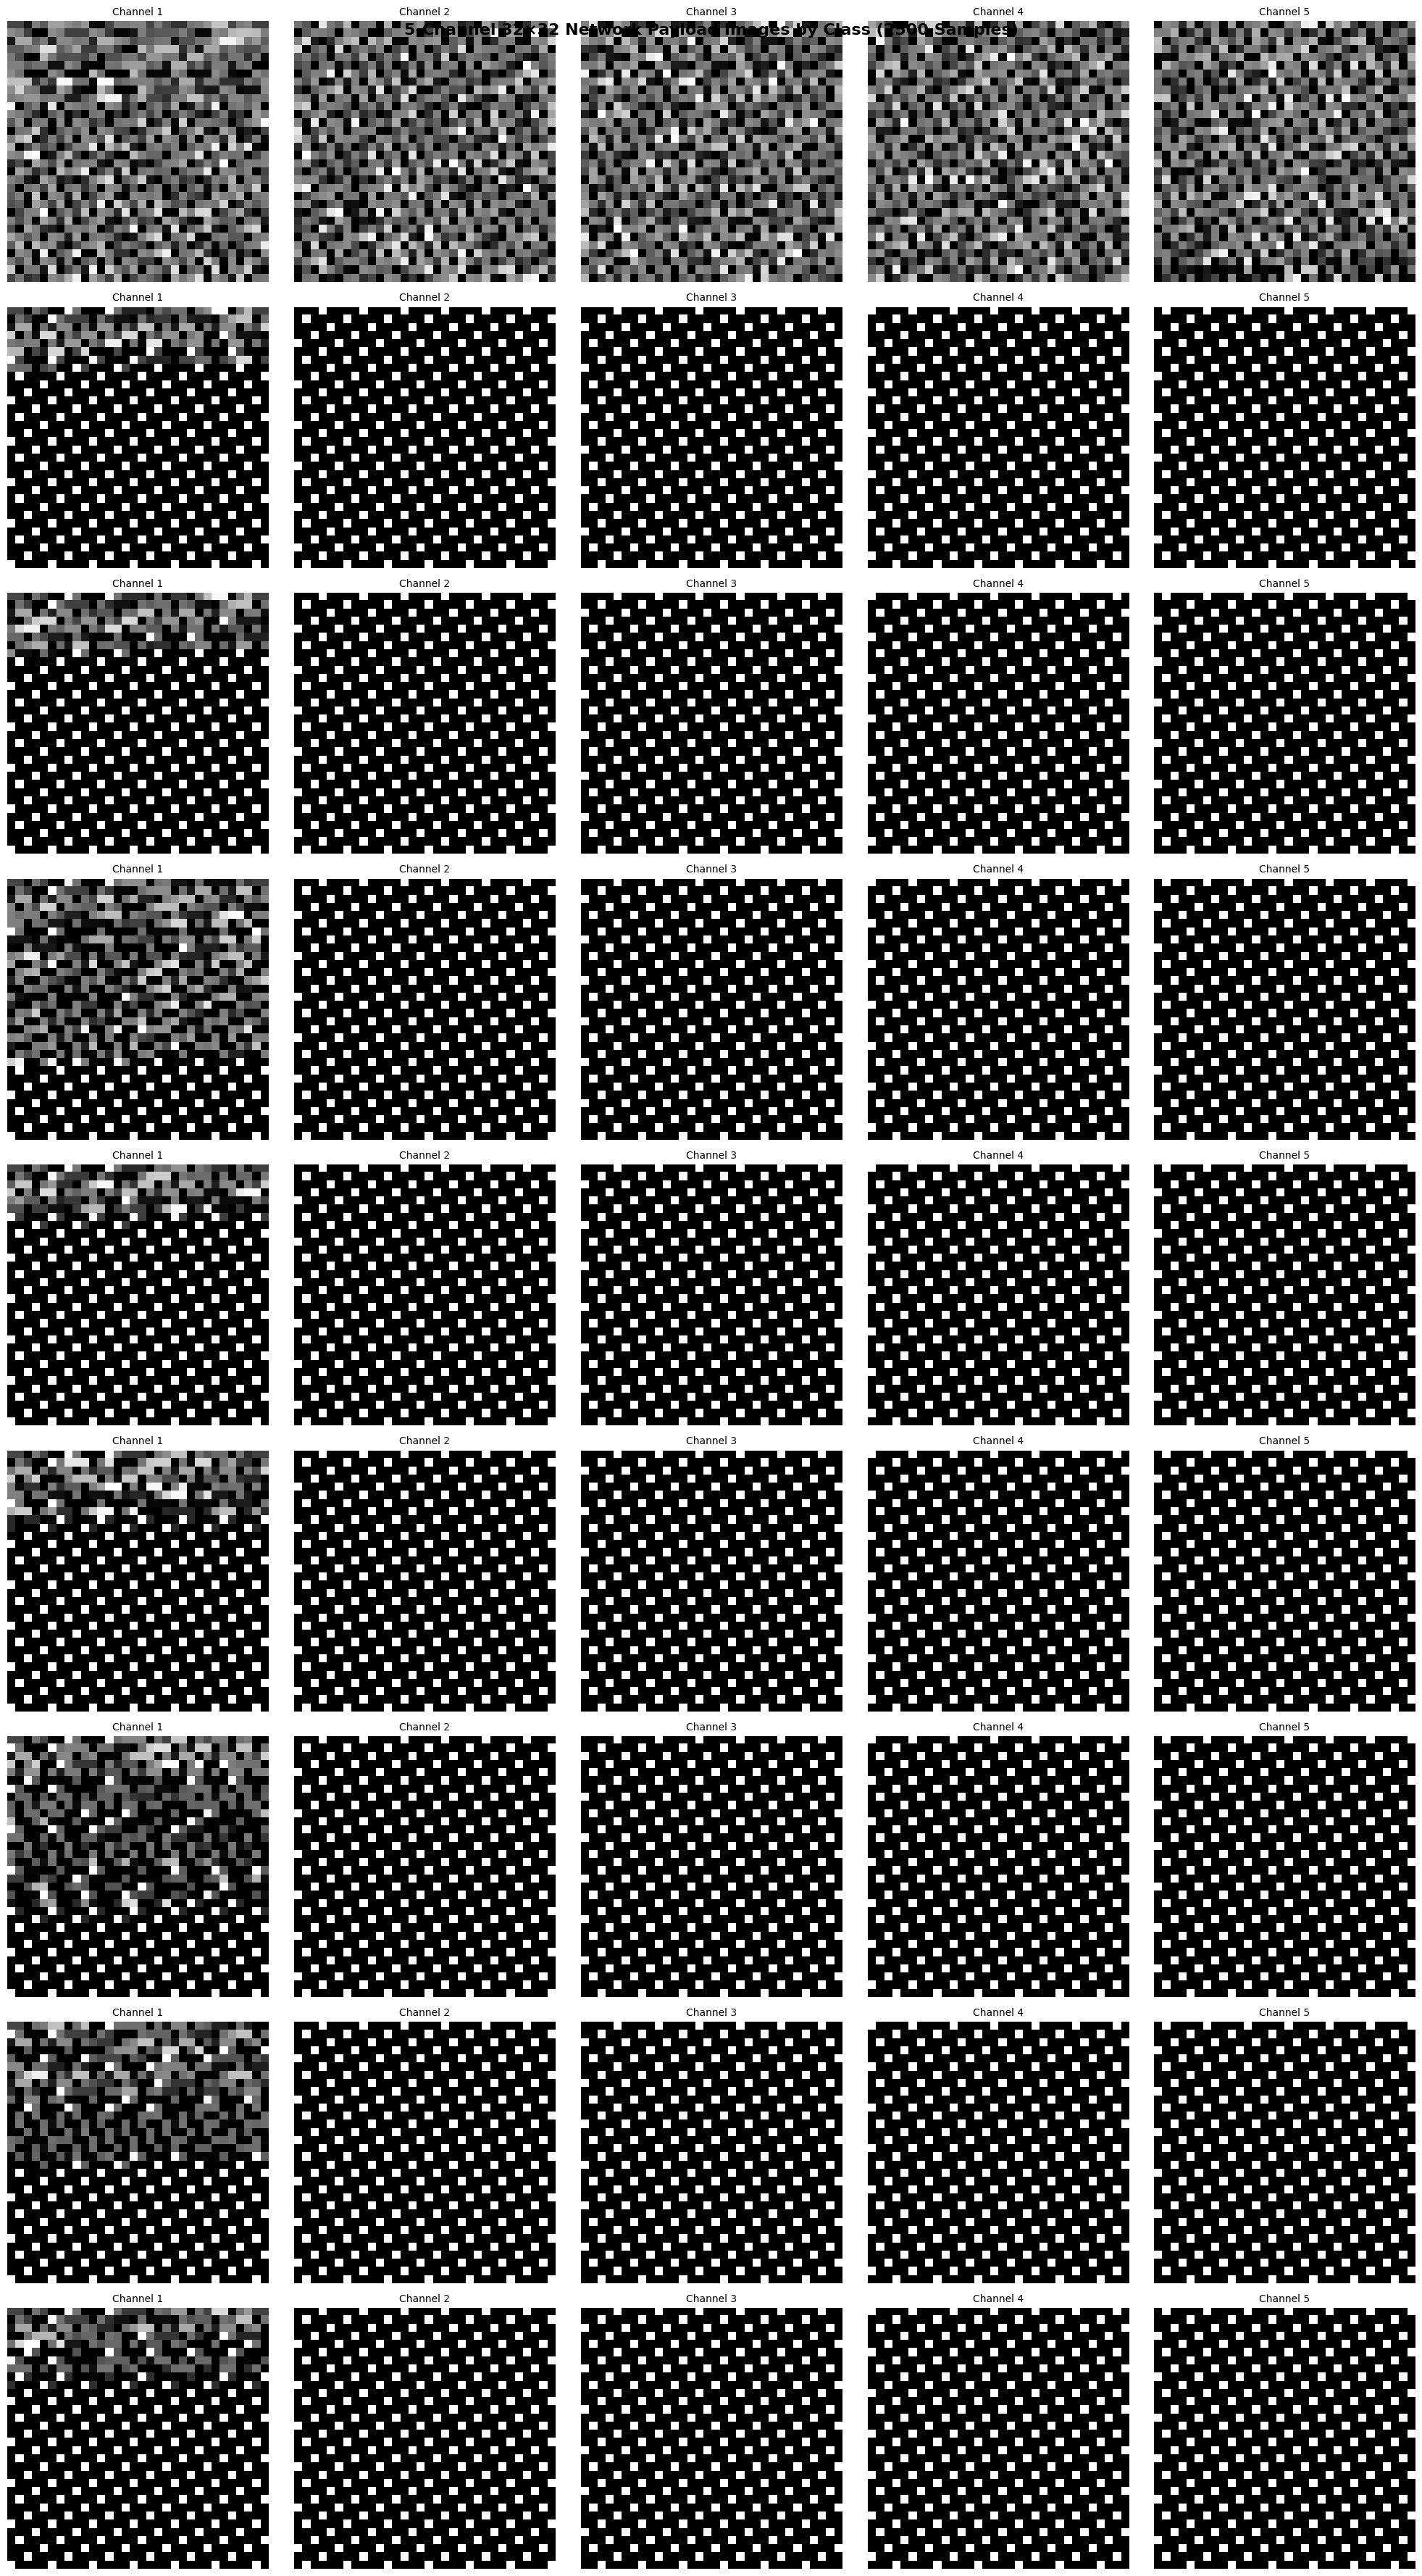


📊 Channel-wise Analysis:
   Channel 1: mean=0.249, std=0.356, nonzero=0.511
   Channel 2: mean=0.218, std=0.380, nonzero=0.319
   Channel 3: mean=0.215, std=0.385, nonzero=0.288
   Channel 4: mean=0.213, std=0.391, nonzero=0.256
   Channel 5: mean=0.212, std=0.391, nonzero=0.253

✓ Data visualization and analysis complete!
✓ Ready for ViT model training with 5-channel input
✓ Sample limit enforced: 2500 per class


In [3]:
# Section 2: Data Reshaping and Visualization
# Reshape data from flat features to 5-channel images
print("Reshaping data to 5-channel images...")

# Expected: (N, 5120) → (N, 5, 32, 32)
expected_features = CONFIG['channels'] * CONFIG['image_size'] ** 2
if X.shape[1] == expected_features:
    # Reshape to (N, channels, height, width)
    X_images = X.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
    print(f"✓ Reshaped to: {X_images.shape}")
else:
    print(f"⚠️ Feature count mismatch: got {X.shape[1]}, expected {expected_features}")
    # Try to adapt - take first N features if more, or pad if fewer
    if X.shape[1] > expected_features:
        X_trimmed = X[:, :expected_features]
        X_images = X_trimmed.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
        print(f"✓ Trimmed and reshaped to: {X_images.shape}")
    else:
        # Pad with zeros
        padding = np.zeros((X.shape[0], expected_features - X.shape[1]))
        X_padded = np.concatenate([X, padding], axis=1)
        X_images = X_padded.reshape(-1, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size'])
        print(f"✓ Padded and reshaped to: {X_images.shape}")

# Normalize images to [0, 1] if needed
if X_images.max() > 1.0:
    X_images = X_images / 255.0
    print(f"✓ Normalized to [0, 1]: [{X_images.min():.3f}, {X_images.max():.3f}]")

# Visualize sample images for each class
num_classes = len(label_encoder.classes_)
fig, axes = plt.subplots(num_classes, CONFIG['channels'], figsize=(20, 4*num_classes))
if num_classes == 1:
    axes = axes.reshape(1, -1)

print(f"\nVisualizing sample images for {num_classes} classes (2500 sample limit)...")

for class_idx in range(num_classes):
    class_name = label_encoder.classes_[class_idx]
    
    # Find first sample of this class
    class_mask = y_encoded == class_idx
    sample_indices = np.where(class_mask)[0]
    
    if len(sample_indices) > 0:
        sample_idx = sample_indices[0]
        sample_image = X_images[sample_idx]
        
        # Show each channel
        for channel in range(CONFIG['channels']):
            ax = axes[class_idx, channel] if num_classes > 1 else axes[channel]
            im = ax.imshow(sample_image[channel], cmap='gray', vmin=0, vmax=1)
            if channel == 0:
                ax.set_ylabel(f'{class_name}', fontsize=12)
            ax.set_title(f'Channel {channel+1}', fontsize=10)
            ax.axis('off')

plt.suptitle('5-Channel 32×32 Network Payload Images by Class (2500 Samples)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Analyze channel statistics
print(f"\n📊 Channel-wise Analysis:")
for channel in range(CONFIG['channels']):
    channel_data = X_images[:, channel, :, :]
    mean_intensity = np.mean(channel_data)
    std_intensity = np.std(channel_data)
    nonzero_ratio = np.mean(channel_data > 0)
    print(f"   Channel {channel+1}: mean={mean_intensity:.3f}, std={std_intensity:.3f}, nonzero={nonzero_ratio:.3f}")

print(f"\n✓ Data visualization and analysis complete!")
print(f"✓ Ready for ViT model training with {CONFIG['channels']}-channel input")
print(f"✓ Sample limit enforced: {CONFIG['max_samples_per_class']} per class")

In [4]:
# Section 3: Multi-Channel Vision Transformer Architecture
class MultiChannelPatchEmbedding(nn.Module):
    """Convert multi-channel images to patch embeddings"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_patches = (img_size // patch_size) ** 2
        
        # Convolutional layer to extract patches from multi-channel input
        self.projection = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        # x shape: (batch_size, in_channels, img_size, img_size)
        x = self.projection(x)  # (batch_size, embed_dim, H', W')
        x = x.flatten(2)        # (batch_size, embed_dim, num_patches)
        x = x.transpose(1, 2)   # (batch_size, num_patches, embed_dim)
        return x

class MultiChannelVisionTransformer(nn.Module):
    """Vision Transformer for Multi-Channel Network Payload Classification"""
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_heads, num_layers, num_classes, dropout=0.1):
        super().__init__()
        
        # Multi-channel patch embedding
        self.patch_embedding = MultiChannelPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embedding.num_patches
        
        # Learnable position embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim))
        
        # Class token (for classification)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=embed_dim * 4,
            dropout=dropout,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        
        # Classification head
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
    
    def forward(self, x):
        batch_size = x.shape[0]
        
        # Convert to patches and embed
        x = self.patch_embedding(x)  # (batch_size, num_patches, embed_dim)
        
        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)  # (batch_size, num_patches + 1, embed_dim)
        
        # Add positional embeddings
        x = x + self.pos_embedding
        x = self.dropout(x)
        
        # Pass through transformer
        x = self.transformer(x)
        
        # Classification from class token
        cls_output = x[:, 0]  # Take the class token
        cls_output = self.norm(cls_output)
        output = self.head(cls_output)
        
        return output

# Initialize the Multi-Channel Vision Transformer
model = MultiChannelVisionTransformer(
    img_size=CONFIG['image_size'],
    patch_size=CONFIG['patch_size'],
    in_channels=CONFIG['channels'],
    embed_dim=CONFIG['embed_dim'],
    num_heads=CONFIG['num_heads'],
    num_layers=CONFIG['num_layers'],
    num_classes=CONFIG['num_classes']
).to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🤖 Multi-Channel Vision Transformer Model (2500 Sample Limit):")
print(f"✓ Input: {CONFIG['channels']}-channel {CONFIG['image_size']}×{CONFIG['image_size']} images")
print(f"✓ Patches per image: {(CONFIG['image_size']//CONFIG['patch_size'])**2}")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")
print(f"✓ Model size: {total_params * 4 / 1024**2:.1f} MB")
print(f"✓ Sample limit: {CONFIG['max_samples_per_class']} per class")

# Test forward pass
sample_input = torch.randn(2, CONFIG['channels'], CONFIG['image_size'], CONFIG['image_size']).to(device)
with torch.no_grad():
    sample_output = model(sample_input)
    print(f"✓ Forward pass test: {sample_input.shape} → {sample_output.shape}")

print(f"\n✓ Multi-channel ViT architecture ready!")
print(f"✓ Configured for {CONFIG['num_classes']} classes: {label_encoder.classes_}")
print(f"✓ Ready for controlled comparison with UNSW dataset")

🤖 Multi-Channel Vision Transformer Model (2500 Sample Limit):
✓ Input: 5-channel 32×32 images
✓ Patches per image: 4
✓ Total parameters: 2,918,409
✓ Trainable parameters: 2,918,409
✓ Model size: 11.1 MB
✓ Sample limit: 2500 per class
✓ Forward pass test: torch.Size([2, 5, 32, 32]) → torch.Size([2, 9])

✓ Multi-channel ViT architecture ready!
✓ Configured for 9 classes: ['Benign_Final' 'DDoS-HTTP_Flood' 'DDoS-SYN_Flood' 'DictionaryBruteForce'
 'DoS-TCP_Flood' 'DoS-UDP_Flood' 'Mirai-udpplain' 'Recon-PortScan'
 'SqlInjection']
✓ Ready for controlled comparison with UNSW dataset


Preparing training pipeline for 2500-sample comparison...
✓ Tensor conversion: X=torch.Size([22500, 5, 32, 32]), y=torch.Size([22500])
✓ Data splits (from 2500 per class):
   Train: 15750 samples
   Val:   3375 samples
   Test:  3375 samples
✓ Class weights: [1. 1. 1. 1. 1. 1. 1. 1. 1.]
✓ Data loaders: 493 train, 106 val, 106 test batches
✓ Training setup complete

🚀 Starting 5-Channel ViT training for 30 epochs...
✓ Fair comparison mode: 2500 samples per class
Epoch  1/30: Train Loss: 1.6188, Train Acc: 42.46% | Val Loss: 1.2476, Val Acc: 55.88%
Epoch  2/30: Train Loss: 1.1776, Train Acc: 59.99% | Val Loss: 1.0726, Val Acc: 64.33%
Epoch  3/30: Train Loss: 1.0441, Train Acc: 64.08% | Val Loss: 0.9432, Val Acc: 66.55%
Epoch  4/30: Train Loss: 0.9312, Train Acc: 67.78% | Val Loss: 0.8375, Val Acc: 70.67%
Epoch  5/30: Train Loss: 0.8462, Train Acc: 70.62% | Val Loss: 0.8091, Val Acc: 71.76%
Epoch  6/30: Train Loss: 0.7776, Train Acc: 73.54% | Val Loss: 0.7198, Val Acc: 74.79%
Epoch  7/30:

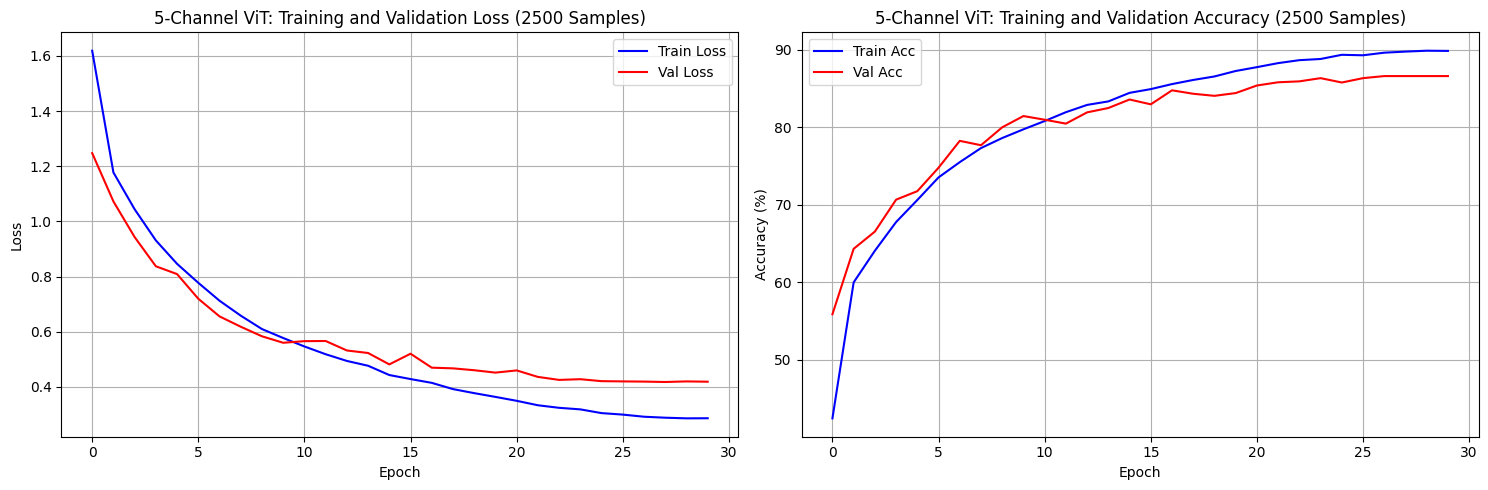


✓ 5-Channel ViT training complete!
✓ Ready for evaluation and comparison with UNSW dataset


In [5]:
# Section 4: Training Pipeline
print("Preparing training pipeline for 2500-sample comparison...")

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_images)
y_tensor = torch.LongTensor(y_encoded)

print(f"✓ Tensor conversion: X={X_tensor.shape}, y={y_tensor.shape}")

# Stratified train/validation/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X_tensor, y_tensor, test_size=0.3, stratify=y_tensor, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"✓ Data splits (from {CONFIG['max_samples_per_class']} per class):")
print(f"   Train: {X_train.shape[0]} samples")
print(f"   Val:   {X_val.shape[0]} samples")
print(f"   Test:  {X_test.shape[0]} samples")

# Calculate class weights for balanced training
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train.numpy()
)
class_weights_tensor = torch.FloatTensor(class_weights).to(device)
print(f"✓ Class weights: {class_weights}")

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

print(f"✓ Data loaders: {len(train_loader)} train, {len(val_loader)} val, {len(test_loader)} test batches")

# Training setup
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=0.01)
scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG['epochs'])

print(f"✓ Training setup complete")

# Training functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

# Training loop
print(f"\n🚀 Starting 5-Channel ViT training for {CONFIG['epochs']} epochs...")
print(f"✓ Fair comparison mode: {CONFIG['max_samples_per_class']} samples per class")
print("=" * 80)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0
patience = 5
patience_counter = 0

for epoch in range(CONFIG['epochs']):
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    # Update scheduler
    scheduler.step()
    
    # Store metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Print progress
    print(f"Epoch {epoch+1:2d}/{CONFIG['epochs']}: "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_5channel_vit_model_limited.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

print("=" * 80)
print(f"✓ Training completed!")
print(f"✓ Best validation accuracy: {best_val_acc:.2f}%")

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(train_losses, label='Train Loss', color='blue')
ax1.plot(val_losses, label='Val Loss', color='red')
ax1.set_title('5-Channel ViT: Training and Validation Loss (2500 Samples)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc', color='blue')
ax2.plot(val_accuracies, label='Val Acc', color='red')
ax2.set_title('5-Channel ViT: Training and Validation Accuracy (2500 Samples)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"\n✓ 5-Channel ViT training complete!")
print(f"✓ Ready for evaluation and comparison with UNSW dataset")

🔍 5-Channel ViT Evaluation on Test Set (2500 Sample Comparison)
🎯 5-Channel ViT Test Results (2500 Sample Comparison):
✓ Test Accuracy: 87.29%
✓ Test Loss: 0.4066
✓ Samples evaluated: 3,375
✓ Sample limit enforced: 2500 per class

📊 Per-Class Performance:
--------------------------------------------------------------------------------

📈 Overall Metrics:
✓ Macro Avg: Precision=0.890, Recall=0.873, F1=0.878
✓ Weighted Avg: Precision=0.890, Recall=0.873, F1=0.878


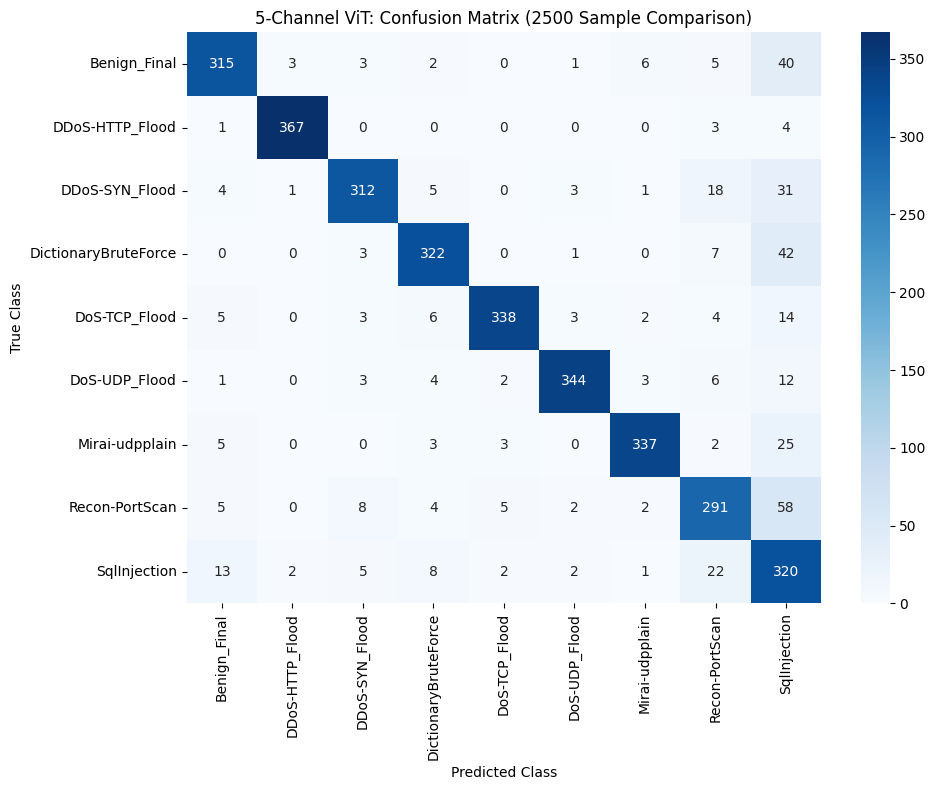


📊 Class-wise Accuracy:
   Benign_Final        :  84.0% (375 samples)
   DDoS-HTTP_Flood     :  97.9% (375 samples)
   DDoS-SYN_Flood      :  83.2% (375 samples)
   DictionaryBruteForce:  85.9% (375 samples)
   DoS-TCP_Flood       :  90.1% (375 samples)
   DoS-UDP_Flood       :  91.7% (375 samples)
   Mirai-udpplain      :  89.9% (375 samples)
   Recon-PortScan      :  77.6% (375 samples)
   SqlInjection        :  85.3% (375 samples)

💡 5-Channel ViT Key Results (2500 Sample Comparison):
✓ Overall test accuracy: 87.29%
✓ Number of classes: 9
✓ Model complexity: 2,918,409 parameters
✓ Input format: 5-channel 32×32 images
✓ Sample limit: 2500 per class (for fair comparison)
✓ Total samples: 22,500 (2,500 per class)

✓ Results saved to results_5channel_32x32_limited.json
✓ 5-Channel ViT evaluation complete!
✓ Ready for direct comparison with UNSW dataset results

🔬 Fair Comparison Enabled:
   • CIC Dataset: 2500 samples per class
   • UNSW Dataset: ~2500 samples per class
   • Same model 

In [6]:
# Section 5: Evaluation & Results Analysis
print("🔍 5-Channel ViT Evaluation on Test Set (2500 Sample Comparison)")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load('best_5channel_vit_model_limited.pth'))
model.eval()

# Comprehensive evaluation
def evaluate_model(model, dataloader, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_predictions = []
    all_targets = []
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            loss = criterion(output, target)
            test_loss += loss.item()
            
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
            
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(dataloader)
    
    return accuracy, avg_loss, np.array(all_predictions), np.array(all_targets)

# Run evaluation
test_accuracy, test_loss, predictions, targets = evaluate_model(model, test_loader, device)

print(f"🎯 5-Channel ViT Test Results (2500 Sample Comparison):")
print(f"✓ Test Accuracy: {test_accuracy:.2f}%")
print(f"✓ Test Loss: {test_loss:.4f}")
print(f"✓ Samples evaluated: {len(targets):,}")
print(f"✓ Sample limit enforced: {CONFIG['max_samples_per_class']} per class")

# Detailed classification report
class_names = label_encoder.classes_
report = classification_report(targets, predictions, target_names=class_names, output_dict=True, zero_division=0)

print(f"\n📊 Per-Class Performance:")
print("-" * 80)

for i, class_name in enumerate(class_names):
    if str(i) in report:
        precision = report[str(i)]['precision']
        recall = report[str(i)]['recall']
        f1 = report[str(i)]['f1-score']
        support = report[str(i)]['support']
        print(f"{class_name:20s}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Support={support:,}")

print(f"\n📈 Overall Metrics:")
print(f"✓ Macro Avg: Precision={report['macro avg']['precision']:.3f}, Recall={report['macro avg']['recall']:.3f}, F1={report['macro avg']['f1-score']:.3f}")
print(f"✓ Weighted Avg: Precision={report['weighted avg']['precision']:.3f}, Recall={report['weighted avg']['recall']:.3f}, F1={report['weighted avg']['f1-score']:.3f}")

# Confusion Matrix
cm = confusion_matrix(targets, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('5-Channel ViT: Confusion Matrix (2500 Sample Comparison)')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Class-wise accuracy analysis
print(f"\n📊 Class-wise Accuracy:")
class_accuracies = []
for i, class_name in enumerate(class_names):
    class_mask = targets == i
    if np.sum(class_mask) > 0:
        class_acc = np.mean(predictions[class_mask] == targets[class_mask]) * 100
        sample_count = np.sum(class_mask)
        class_accuracies.append((class_name, class_acc, sample_count))
        print(f"   {class_name:20s}: {class_acc:5.1f}% ({sample_count:,} samples)")

# Performance summary
print(f"\n💡 5-Channel ViT Key Results (2500 Sample Comparison):")
print(f"✓ Overall test accuracy: {test_accuracy:.2f}%")
print(f"✓ Number of classes: {CONFIG['num_classes']}")
print(f"✓ Model complexity: {total_params:,} parameters")
print(f"✓ Input format: {CONFIG['channels']}-channel {CONFIG['image_size']}×{CONFIG['image_size']} images")
print(f"✓ Sample limit: {CONFIG['max_samples_per_class']} per class (for fair comparison)")
print(f"✓ Total samples: {len(y):,} ({len(y)//CONFIG['num_classes']:,} per class)")

# Save results for comparison
results_5channel_limited = {
    'model_type': '5channel_32x32_limited',
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'num_classes': CONFIG['num_classes'],
    'num_parameters': total_params,
    'sample_limit': CONFIG['max_samples_per_class'],
    'total_samples': len(y),
    'class_accuracies': class_accuracies,
    'confusion_matrix': cm.tolist(),
    'classification_report': report
}

import json
with open('results_5channel_32x32_limited.json', 'w') as f:
    json.dump(results_5channel_limited, f, indent=2, default=str)

print(f"\n✓ Results saved to results_5channel_32x32_limited.json")
print(f"✓ 5-Channel ViT evaluation complete!")
print(f"✓ Ready for direct comparison with UNSW dataset results")
print(f"\n🔬 Fair Comparison Enabled:")
print(f"   • CIC Dataset: {CONFIG['max_samples_per_class']} samples per class")
print(f"   • UNSW Dataset: ~2500 samples per class")
print(f"   • Same model architecture and training procedure")